In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from pysal.lib import weights
from pysal.explore import esda
from shapely.geometry import Point
import geopandas as gpd
import contextily as ctx

C:\Users\JUMIA-4237\AppData\Roaming\Python\Python311\site-packages\spaghetti\network.py:42: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [2]:
file_path = r"C:\Users\JUMIA-4237\Desktop\Thesisoption\arrest_SPQ.csv"

In [3]:
SH = pd.read_csv(file_path)

In [4]:
SH.head(3)

,Type,Date,Part of a policing operation,Latitude,Longitude,Object of search,Outcome,Anything to threaten or harm anyone,Articles for use in criminal damage,Controlled drugs,Evidence of offences under the Act,Firearms,Offensive weapons,Stolen goods
0,Person search,2021-03-31T23:09:00+00:00,False,51.418969,-0.147822,Controlled drugs,Arrest,0,0,1,0,0,0,0
1,Person search,2021-03-31T23:17:00+00:00,False,51.498727,-0.105172,Evidence of offences under the Act,Arrest,0,0,0,1,0,0,0
2,Person and Vehicle search,2021-03-31T23:25:00+00:00,False,51.530467,-0.388379,Controlled drugs,Arrest,0,0,1,0,0,0,0


In [5]:
file_path1 = r"C:\Users\JUMIA-4237\Desktop\Thesisoption\combined_df_crime.csv"

In [6]:
combined_df = pd.read_csv(file_path1)

In [7]:
combined_df.head(3)

,Month,Longitude,Latitude,Location,LSOA code,Last outcome category,Anti-social behaviour,Bicycle theft,Burglary,Criminal damage and arson,Drugs,Other crime,Other theft,Possession of weapons,Public order,Robbery,Shoplifting,Theft from the person,Vehicle crime,Violence and sexual offences
0,2021-05,-0.664242,50.791718,On or near Brooks Lane,E01031433,Investigation complete; no suspect identified,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2021-05,-0.664242,50.791718,On or near Brooks Lane,E01031433,Status update unavailable,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2021-05,-1.258193,53.127960,On or near Park Street,E01027967,Investigation complete; no suspect identified,0,0,0,0,0,0,0,0,0,0,0,0,0,1


Local Moran's I for Bicycle theft and Stolen goods:
Mean Moran's I: 0.2554
Mean p-value: 0.1752
Mean z-score: 0.5426


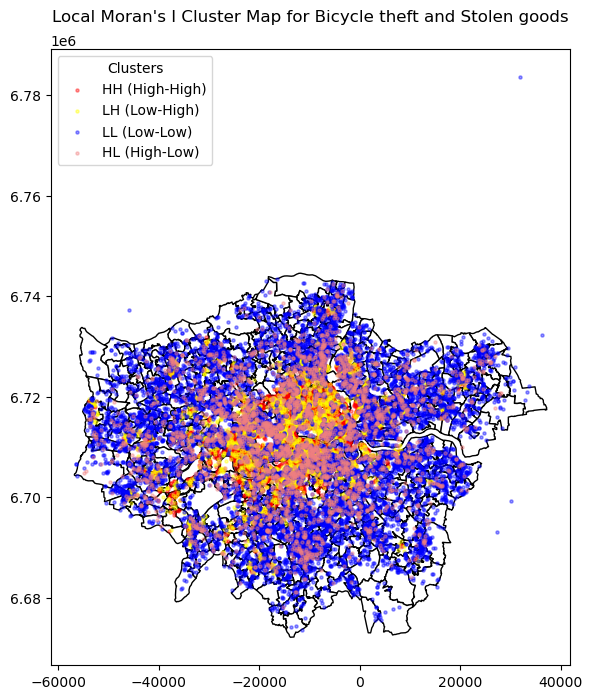

Local Moran's I for Burglary and Stolen goods:
Mean Moran's I: 0.1356
Mean p-value: 0.2029
Mean z-score: 0.3051


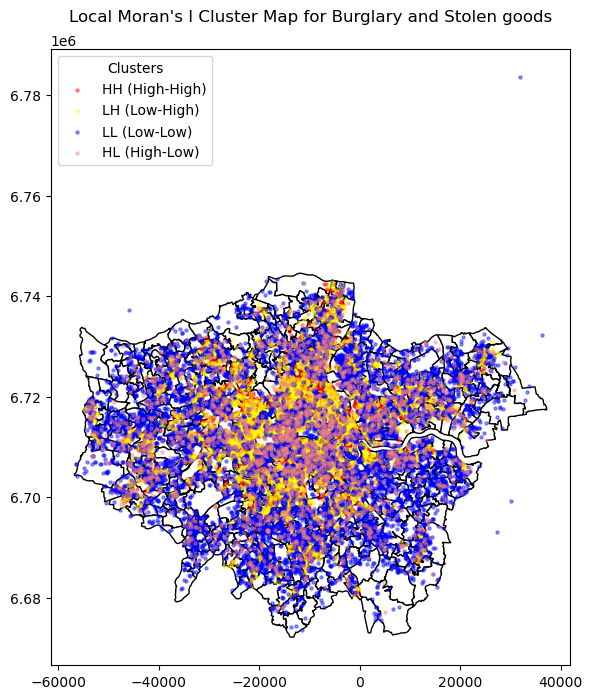

Local Moran's I for Criminal damage and arson and Articles for use in criminal damage:
Mean Moran's I: 0.1105
Mean p-value: 0.2178
Mean z-score: 0.2242


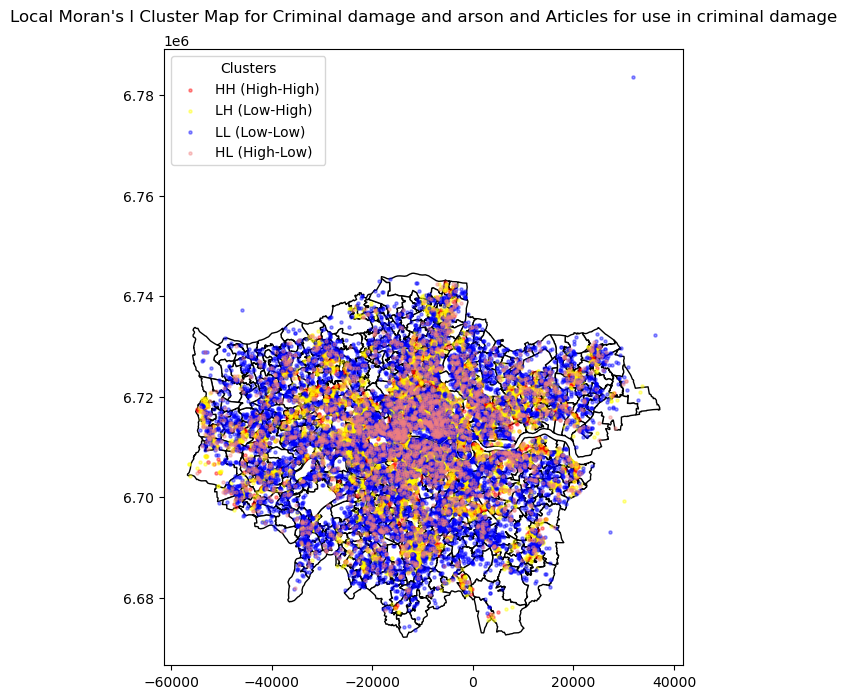

Local Moran's I for Drugs and Controlled drugs:
Mean Moran's I: 0.2474
Mean p-value: 0.2118
Mean z-score: 0.3843


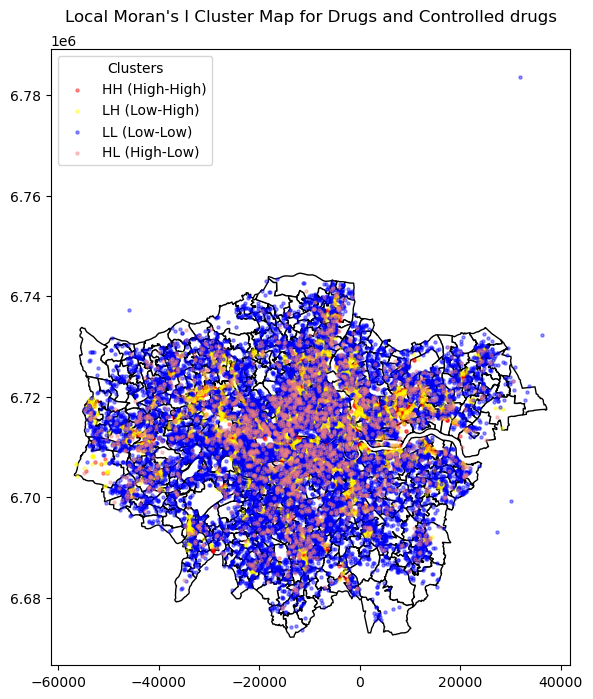

Local Moran's I for Other theft and Stolen goods:
Mean Moran's I: 0.3120
Mean p-value: 0.2077
Mean z-score: 0.4583


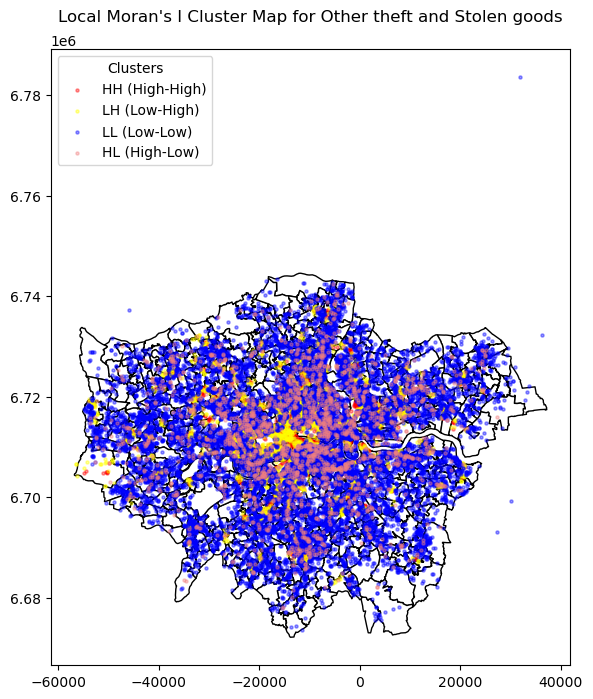

Local Moran's I for Possession of weapons and Offensive weapons:
Mean Moran's I: 0.1082
Mean p-value: 0.2632
Mean z-score: 0.1601


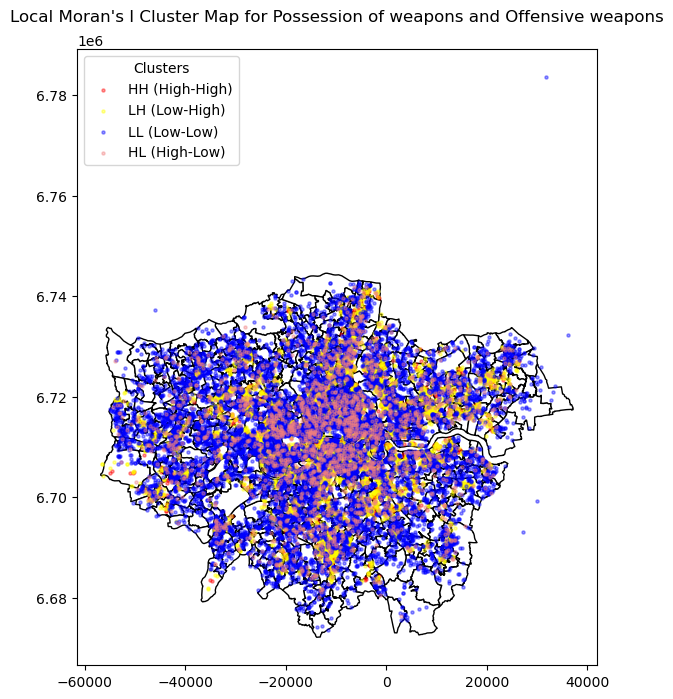

Local Moran's I for Robbery and Stolen goods:
Mean Moran's I: 0.3122
Mean p-value: 0.1975
Mean z-score: 0.4604


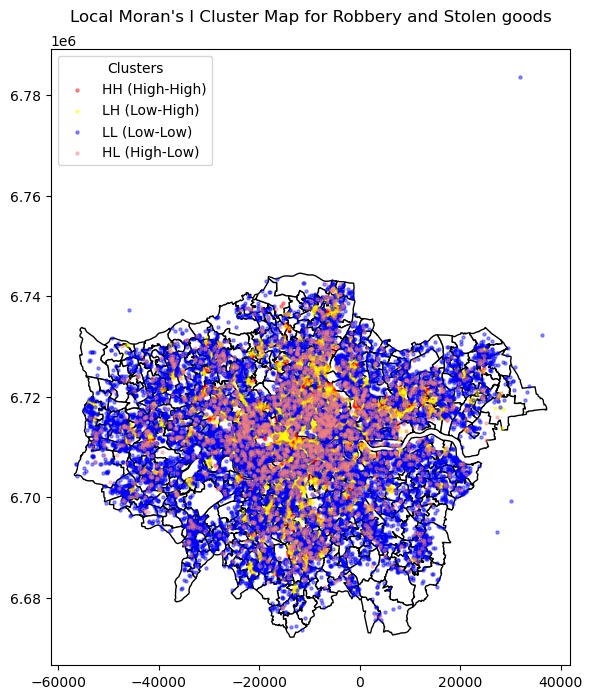

Local Moran's I for Shoplifting and Stolen goods:
Mean Moran's I: 0.1342
Mean p-value: 0.2323
Mean z-score: 0.2208


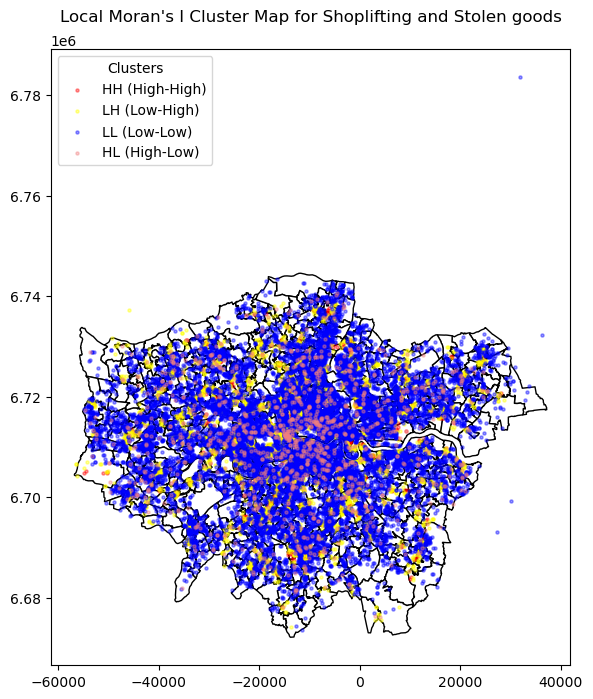

Local Moran's I for Theft from the person and Stolen goods:
Mean Moran's I: 0.3414
Mean p-value: 0.1646
Mean z-score: 0.4385


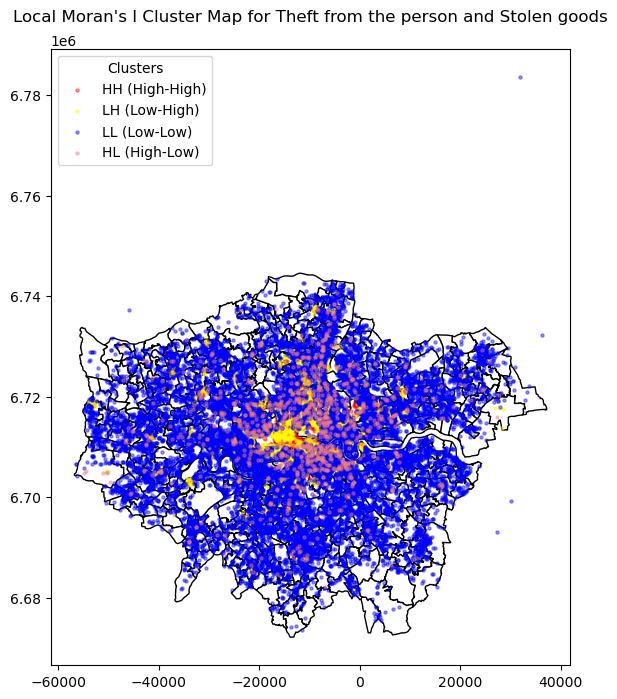

Local Moran's I for Violence and sexual offences and Evidence of offences under the Act:
Mean Moran's I: 0.1750
Mean p-value: 0.2042
Mean z-score: 0.3636


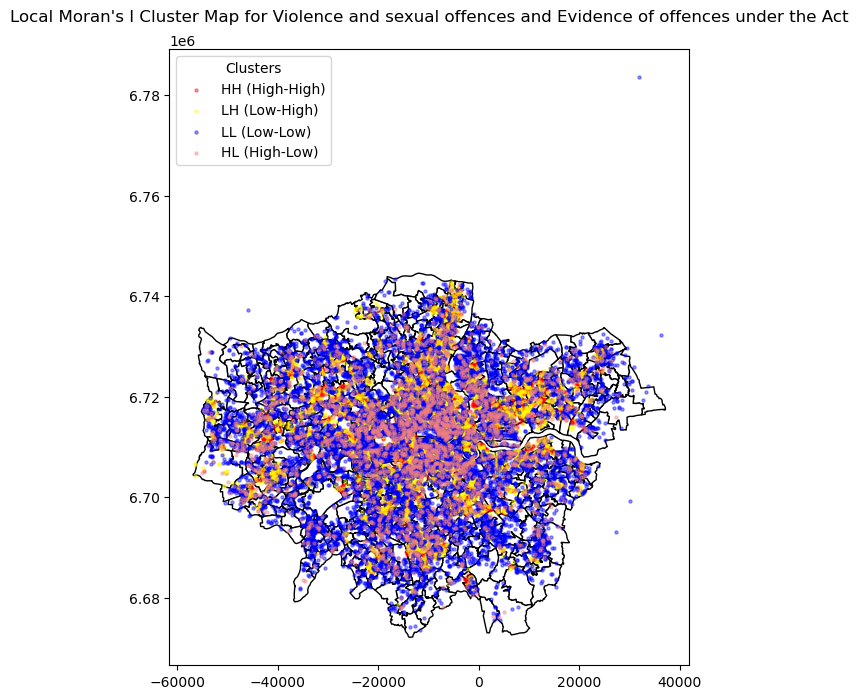

In [48]:
london_msoa = gpd.read_file("C:\\Users\\JUMIA-4237\\Downloads\\statistical-gis-boundaries-lon\\statistical-gis-boundaries-london\\ESRI\\MSOA_2011_London_gen_MHW.shp")

matched_categories = [
    ('Bicycle theft', 'Stolen goods'),
    ('Burglary', 'Stolen goods'),
    ('Criminal damage and arson', 'Articles for use in criminal damage'),
    ('Drugs', 'Controlled drugs'),
    ('Other theft', 'Stolen goods'),
    ('Possession of weapons', 'Offensive weapons'),
    ('Robbery', 'Stolen goods'),
    ('Shoplifting', 'Stolen goods'),
    ('Theft from the person', 'Stolen goods'),
    ('Violence and sexual offences', 'Evidence of offences under the Act')
]

def extract_relevant_data(combined_df, SH, crime_cat, arrest_cat):
    crime_data = combined_df[['Longitude', 'Latitude', crime_cat]]
    arrest_data = SH[['Longitude', 'Latitude', arrest_cat]]
    
    crime_data = crime_data.groupby(['Longitude', 'Latitude'])[crime_cat].sum().reset_index()
    arrest_data = arrest_data.groupby(['Longitude', 'Latitude'])[arrest_cat].sum().reset_index()
    
    merged_data = pd.merge(crime_data, arrest_data, on=['Longitude', 'Latitude'])
    return merged_data

def calculate_local_morans_I(data, crime_cat, arrest_cat):
    gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.Longitude, data.Latitude))
    gdf.set_crs(epsg=4326, inplace=True)
    
    w = weights.KNN.from_dataframe(gdf, k=8)
    w.transform = 'R'
    
    y1 = gdf[crime_cat].values
    moran_loc = esda.moran.Moran_Local(y1, w)
    
    return moran_loc, gdf

results = {}
for crime_cat, arrest_cat in matched_categories:
    data = extract_relevant_data(combined_df, SH, crime_cat, arrest_cat)
    moran_loc, gdf = calculate_local_morans_I(data, crime_cat, arrest_cat)
    results[(crime_cat, arrest_cat)] = (moran_loc, gdf)

def plot_local_morans_I(moran_loc, gdf, column, title, stats_text):
    gdf['Is'] = moran_loc.Is
    gdf['q'] = moran_loc.q
    
    cluster_labels = {
        1: "HH (High-High)",
        2: "LH (Low-High)",
        3: "LL (Low-Low)",
        4: "HL (High-Low)"
    }
    cluster_colors = {
        1: "red",
        2: "yellow",
        3: "blue",
        4: "lightcoral"
    }
    
    gdf['cluster'] = gdf['q'].map(cluster_labels)
    gdf['color'] = gdf['q'].map(cluster_colors)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    london_msoa.to_crs(epsg=3857).plot(ax=ax, color='white', edgecolor='black')
    gdf = gdf.to_crs(epsg=3857)  # Transform to Web Mercator for basemap
    for key, color in cluster_colors.items():
        gdf[gdf['q'] == key].plot(ax=ax, color=color, markersize=5, alpha=0.4, label=cluster_labels[key])
    
    plt.title(title, pad=20)
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='upper left', title='Clusters')
    
    plt.show()

for key, value in results.items():
    moran_loc, gdf = value
    stats_text = (f"Mean Moran's I: {moran_loc.Is.mean():.4f}\n"
                  f"Mean p-value: {moran_loc.p_sim.mean():.4f}\n"
                  f"Mean z-score: {moran_loc.z_sim.mean():.4f}")
    
    print(f"Local Moran's I for {key[0]} and {key[1]}:")
    print(stats_text)
    
    plot_local_morans_I(moran_loc, gdf, key[0], f"Local Moran's I Cluster Map for {key[0]} and {key[1]}", stats_text)
